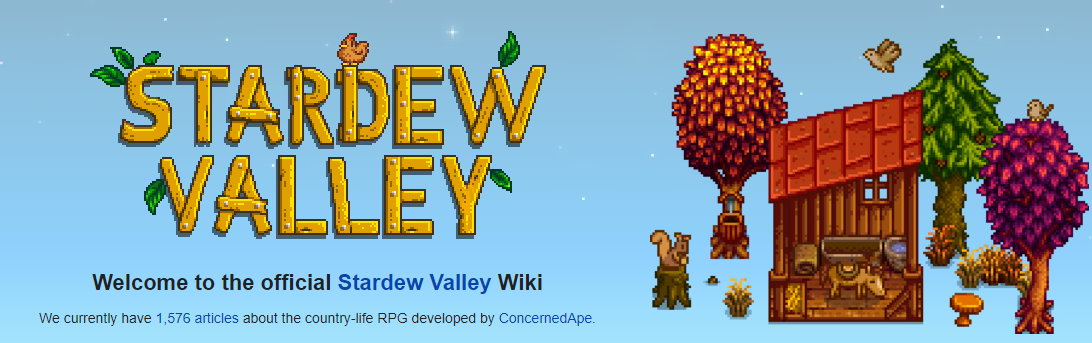

## Stardew Valley Crop Information

I love Stardew Valley - nothing more to be said. I spend a lot of time on the wiki looking up crop information and I got curious about how I could compile all that info into some graphs. Having just started my career in data science, I wanted to put some new found skills into action and explore the data from a game I adore.

performed using the tutorial from JustIntoData

want to extract: crop name, base sell price, growth days, gold per day (base) and season.

Handy links:
* https://regex101.com/

So let's get started!

### Import Packages

In [33]:
# basic packages
import pandas as pd
import re
import numpy as np
# for web scraping
import requests
from bs4 import BeautifulSoup
# for storing and reading dictionary
import pickle as pkl
# for viz
import matplotlib.pyplot as plt
import seaborn as sns

### Initial Web Scraping
The easiest way to retrieve all of the crop names was from the /Crops page. As I wanted to get information relating to artisan goods I couldn't just use this page to get growth time, season info and sell prices. The print out's here just verify what page I visited and if it was successful (200 means we're all good!)

In [5]:
# request website's data
response = requests.get('https://stardewvalleywiki.com/Crops')
print('Visited URL: {}'.format(response.url))
print(response.status_code)

Visited URL: https://stardewvalleywiki.com/Crops
200


Let's save the webpage html so we don't have to continously keep accessing the page - this is good practice because we don't want to take up the page's bandwidth

In [6]:
#parse HTML doc with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

<i> the per crop scraping would go here too

#### Find headings

Let's first look at the output of soup and identify the headings that are our crop names. We have to scroll quite far but eventually we will find our headings. The span class `toctext` is what we will use to extract the text with the `find_all` function.

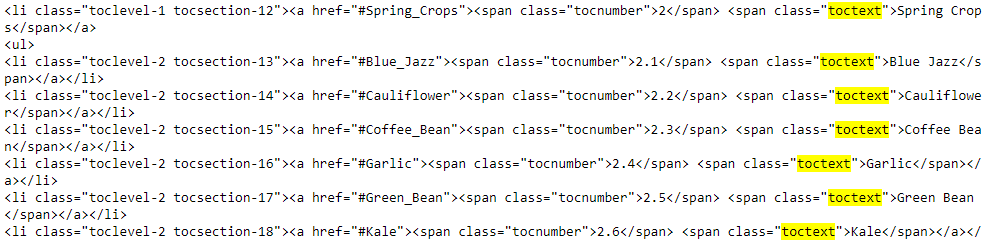

In [14]:
#extract all div tags with the specific class we want
crop_name = soup.find_all('span',class_='toctext')

#loop through div tags to create list of text only
all_crop_names = []
for name in crop_name:
    crop = name.text
    all_crop_names.append(crop)
    
print(all_crop_names)

['Basics', 'Monsters', 'Crows', 'Farm Animals', 'Fertilizing and Planting', 'Trellis Crops', 'Grow Times', 'End of Season', 'Giant Crops', 'Crop Quality', 'Gold per Day', 'Spring Crops', 'Blue Jazz', 'Cauliflower', 'Coffee Bean', 'Garlic', 'Green Bean', 'Kale', 'Parsnip', 'Potato', 'Rhubarb', 'Strawberry', 'Tulip', 'Unmilled Rice', 'Summer Crops', 'Blueberry', 'Corn', 'Hops', 'Hot Pepper', 'Melon', 'Poppy', 'Radish', 'Red Cabbage', 'Starfruit', 'Summer Spangle', 'Sunflower', 'Tomato', 'Wheat', 'Fall Crops', 'Amaranth', 'Artichoke', 'Beet', 'Bok Choy', 'Cranberries', 'Eggplant', 'Fairy Rose', 'Grape', 'Pumpkin', 'Yam', 'Winter Crops', 'Special Crops', 'Ancient Fruit', 'Cactus Fruit', 'Fiber', 'Mixed Seeds', 'Pineapple', 'Taro Root', 'Sweet Gem Berry', 'Tea Leaves', 'Wild Seeds', 'Artisan Goods', 'Achievements', 'Notes', 'External Links', 'References', 'History']


As this was the overview page of all the crops, there are many headings that are irrelevant like "Basics", "Monsters", etc. All we need is from Blue Jazz to Sweet Gem berry.

In [15]:
#filter for just crops
all_extracted_names = all_crop_names[all_crop_names.index("Blue Jazz"): all_crop_names.index("Tea Leaves")]

In [16]:
print(all_extracted_names)

['Blue Jazz', 'Cauliflower', 'Coffee Bean', 'Garlic', 'Green Bean', 'Kale', 'Parsnip', 'Potato', 'Rhubarb', 'Strawberry', 'Tulip', 'Unmilled Rice', 'Summer Crops', 'Blueberry', 'Corn', 'Hops', 'Hot Pepper', 'Melon', 'Poppy', 'Radish', 'Red Cabbage', 'Starfruit', 'Summer Spangle', 'Sunflower', 'Tomato', 'Wheat', 'Fall Crops', 'Amaranth', 'Artichoke', 'Beet', 'Bok Choy', 'Cranberries', 'Eggplant', 'Fairy Rose', 'Grape', 'Pumpkin', 'Yam', 'Winter Crops', 'Special Crops', 'Ancient Fruit', 'Cactus Fruit', 'Fiber', 'Mixed Seeds', 'Pineapple', 'Taro Root', 'Sweet Gem Berry']


We still have a few unnecessary headings that aren't crops, so let's manually remove these

In [17]:
# list of non-crops
not_crops = ['Summer Crops', 'Fall Crops', 'Winter Crops', 'Special Crops', 'Fiber', 'Mixed Seeds']

# remove non-crops
all_crop_names = [name for name in all_extracted_names if name not in not_crops]

In [18]:
print(all_crop_names)

['Blue Jazz', 'Cauliflower', 'Coffee Bean', 'Garlic', 'Green Bean', 'Kale', 'Parsnip', 'Potato', 'Rhubarb', 'Strawberry', 'Tulip', 'Unmilled Rice', 'Blueberry', 'Corn', 'Hops', 'Hot Pepper', 'Melon', 'Poppy', 'Radish', 'Red Cabbage', 'Starfruit', 'Summer Spangle', 'Sunflower', 'Tomato', 'Wheat', 'Amaranth', 'Artichoke', 'Beet', 'Bok Choy', 'Cranberries', 'Eggplant', 'Fairy Rose', 'Grape', 'Pumpkin', 'Yam', 'Ancient Fruit', 'Cactus Fruit', 'Pineapple', 'Taro Root', 'Sweet Gem Berry']


Now we have a list of all the available crops.  
<br>
To get information like type, season, sell prices, etc. about each crop we will need to visit each crop's page. 
To do this we need to replace the spaces in two word names with an underscore, that way we can add it to the URL 
and go straight there.

In [19]:
#replace spaces in names with _ to read id in next step 
all_crop_names = [x.replace(" ", "_") for x in all_crop_names]

Let's save this list to a file as we had to do a lot of work to get it cleaned up

In [ ]:
with open('crop_names_list.txt', 'w') as file:
    for name in all_crop_names:
        file.write(name + '|')

### Getting Crop Info

Let's first look at extracting information for Blue Jazz flowers. The image below shows what the page looks like and highlighted is the information we want to extract.

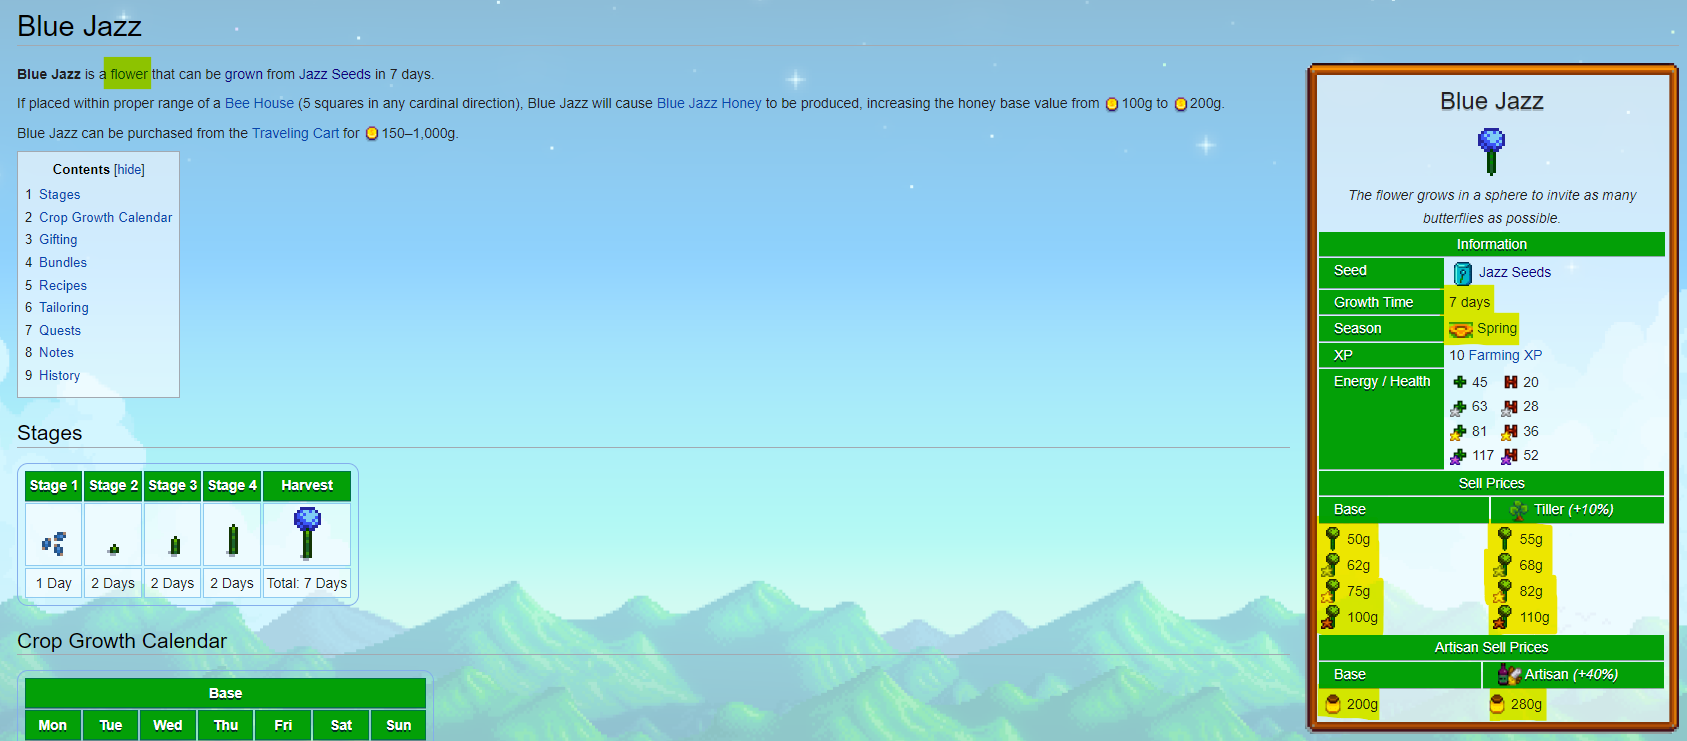

Let's write a function to extract any crop

In [5]:
def get_crop_info(crop_name):
    #request website's data for each crop name
    web_url = 'https://stardewvalleywiki.com/' + crop_name
    response = requests.get(web_url)

    #read html
    crop_soup = BeautifulSoup(response.text, 'html.parser')
    
    return crop_soup    

In [95]:
blue_jazz = get_crop_info('Blue_Jazz')

Feel free to read through the output of `crop_soup`, it is long and can be difficult to understand. A good way to find the classnames of the elements you're looking for is by going to the webpage and opening up the Inspect Element view. This will highlight sections as you hover over them. In this example we can see that "Growth Time" is stored in a `td` element with an id `infoboxdetail`. We can use `crop_soup.find_all('td', id = 'infoboxdetail')` to extract only elements that have the same id.

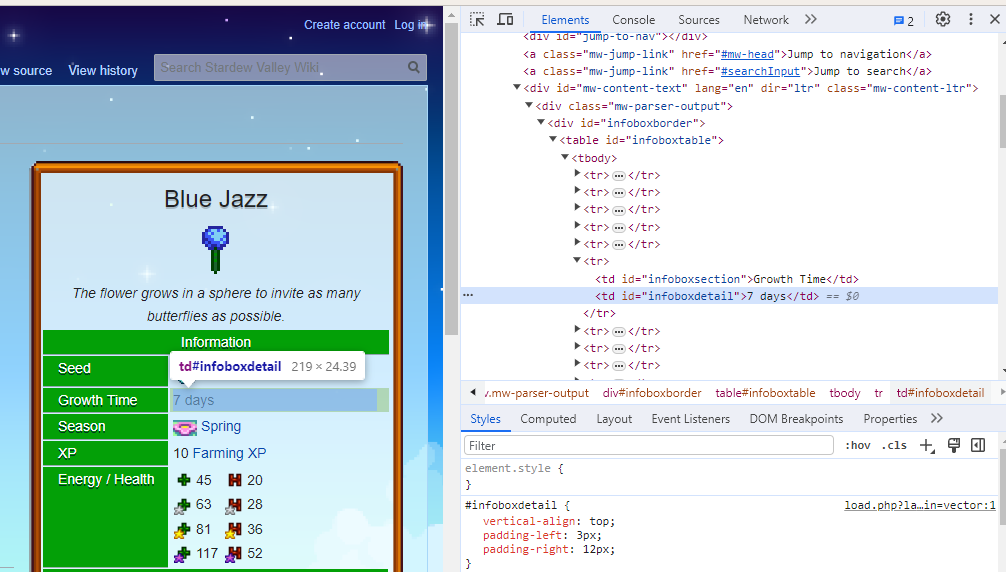

So, let's go ahead and do it!

#### Growth Time

In [96]:
# get info box section and detail
all_infoboxsection = blue_jazz.find_all('td',id='infoboxsection') 
#gets info
all_infoboxdetail = blue_jazz.find_all('td', id = 'infoboxdetail') 

Here, I've extracted `infoboxsection` as well. This is so we can be sure `infoboxdetail` is the correct one. We need to extract only text, which we can do with the following code:

In [97]:
all_infoboxsection[2].text

'Growth Time'

Note that each infoboxsection must be accessed with an index.

Using the same index for `infoboxdetail` will give us the Growth Time as '7 days', but we only want the digit.

In [98]:
growth_text = all_infoboxdetail[2].text

print(growth_text)

# remove 'days' and convert to int
print(int(growth_text.replace('days','')))

7 days
7


#### Season

The same method can be used to get the season of the crop. 

In [99]:
print(all_infoboxsection[3].text)

season_text = all_infoboxdetail[3].text

# Remove space around text
print(season_text.split())

Season
['Spring']


#### Crop Type

We can get crop type from the beginning text on the page

In [109]:
blue_jazz_first_text = blue_jazz.find_all('p')[0].text
print(blue_jazz_first_text)
re.findall(r'(flower)', blue_jazz_first_text)

Blue Jazz is a flower that can be grown from Jazz Seeds in 7 days.



['flower']

--------------